## STEP 0: IMPORT LIBRARIES AND VARIABLES

In [1]:
import pandas
import requests
from protmapper import uniprot_client
from indra.databases.hgnc_client import get_hgnc_name
from gseapy import enrichr
import networkx as nx
import plotly.graph_objects as go
import math
import random

/Users/tonywu/workspace/IndraDemo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
DATASET_NAME = "SMALL_MOLECULE_INTERVENTION"
DATASET_PATH = "model.csv"
DATASET_VALUES = ["BREAST_CANCER", "SMALL_MOLECULE_INTERVENTION"]
LABELS = ["DMSO-DbET6"]
P_VALUE_CONSTRAINT = 0.05

## STEP 1: FETCH DATA FROM INDRA

In [40]:
def search_uniprot(mnemonic_id):
    protein_id = uniprot_client.get_id_from_mnemonic(mnemonic_id)
    if protein_id:
        return uniprot_client.get_hgnc_id(protein_id)
    else:
        return None

In [41]:
def construct_df(filename):
    pandas_df = pandas.read_csv(filename)
    if DATASET_NAME == "BREAST_CANCER":
        pandas_df[['sp', 'Protein', 'Gene']] = pandas_df['Protein'].str.split('|', expand=True)
        pandas_df = pandas_df.loc[pandas_df['adj.pvalue'] < P_VALUE_CONSTRAINT]
        pandas_df['HGNC'] = pandas_df['Protein'].apply(lambda protein_id: uniprot_client.get_hgnc_id(protein_id))
    elif DATASET_NAME == "SMALL_MOLECULE_INTERVENTION":
        pandas_df = pandas_df.loc[pandas_df['adj.pvalue'] < P_VALUE_CONSTRAINT]
        pandas_df = pandas_df.loc[pandas_df['issue'].isnull()]
        pandas_df = pandas_df.loc[pandas_df['Label'].isin(LABELS)]
        pandas_df['HGNC'] = pandas_df['Protein'].apply(
            lambda mnemonic_id: search_uniprot(mnemonic_id)
        )
        pandas_df = pandas_df.loc[pandas_df['HGNC'].notnull()]
    return pandas_df

In [42]:
def create_groundings(df):
    hgnc_ids = set()
    groundings = {}
    for index, row in df.iterrows():
        hgnc_ids.add(row['HGNC'])
    for index, entry in enumerate(hgnc_ids):
        groundings[index] = 'HGNC', entry
    return groundings

In [43]:
def query_indra(filename):
    pandas_df = construct_df(filename)
    groundings = create_groundings(pandas_df)
    res = requests.post(
        'https://discovery.indra.bio/api/indra_subnetwork_relations',
        json={'nodes': list(groundings.values())}
    )
    return res

res = query_indra(DATASET_PATH)

In [44]:
res.json()[0]

{'data': {'belief': 0.65,
  'evidence_count': 1,
  'has_database_evidence': False,
  'has_reader_evidence': True,
  'has_retracted_evidence': False,
  'medscan_only': False,
  'source_counts': '{"sparser": 1}',
  'sparser_only': True,
  'stmt_hash': 6100415255007272,
  'stmt_json': '{"type": "Complex", "members": [{"name": "RAD21", "db_refs": {"UP": "O60216", "TEXT": "RAD21", "HGNC": "9811", "EGID": "5885"}}, {"name": "BRD2", "db_refs": {"UP": "P25440", "TEXT": "BRD2", "HGNC": "1103", "EGID": "6046"}}, {"name": "BRD4", "db_refs": {"UP": "O60885", "TEXT": "BRD4", "HGNC": "13575", "EGID": "23476"}}], "belief": 0.65, "evidence": [{"source_api": "sparser", "pmid": "28107481", "text": "However, we were unable to demonstrate any direct physical interaction between BRD2 or BRD4 with cohesin subunit RAD21 ( xref ), suggesting the conformational control of KSHV latency involves additional factors.", "annotations": {"found_by": "INTERACT"}, "text_refs": {"PMID": "28107481", "TRID": 16352739, "PM

## STEP 2: CONSTRUCT NETWORKX GRAPH OBJECT

In [45]:
def initialize_networkx_graph(res):
    output = res.json()
    G = nx.DiGraph()
    for entry in output:
        if entry['data']['stmt_type'] == 'Complex':
            G.add_node(entry['source_id'])
            G.add_node(entry['target_id'])
            if G.has_edge(entry['target_id'], entry['source_id']):
                if (entry['data']['evidence_count']
                        <= G.get_edge_data(entry['target_id'], entry['source_id'])['evidence']):
                    # Accounts for bidirectional edges for now
                    continue
            G.add_edge(
                entry['source_id'],
                entry['target_id'],
                evidence=entry['data']['evidence_count'],
                belief=entry['data']['belief'],
                type=entry['data']['stmt_type']
            )

    return G

In [46]:
def find_communities(G, weight='evidence'):
    return nx.community.louvain_communities(G, weight=weight)

In [47]:
def generate_node_initial_positions(G, communities):
    initial_pos = {}
    circle_r = 1
    big_r = 1
    pi = math.pi
    centers = [(math.cos(2 * pi / len(communities) * x) * big_r, math.sin(2 * pi / len(communities) * x) * big_r)
               for x in range(0, len(communities))]
    for index, nodes in enumerate(communities):
        for node in nodes:
            alpha = 2 * math.pi * random.random()
            r = circle_r * math.sqrt(random.random())
            x = r * math.cos(alpha) + centers[index][0]
            y = r * math.sin(alpha) + centers[index][1]
            initial_pos[node] = [x, y]
            nx.set_node_attributes(G, {node: index}, name='community')
    
    return initial_pos

In [48]:
def apply_layout_to_graph(G, initial_pos, k = 30, iterations = 100, weight = 'evidence'):
    pos = nx.spring_layout(G, weight=weight, k=k / math.sqrt(len(G.nodes)), pos=initial_pos, iterations=iterations)
    for node in G.nodes():
        x = pos[node][0]
        y = pos[node][1]
        nx.set_node_attributes(G, {node: [x, y]}, name='pos')
    return G

In [49]:
def apply_gsea_to_graph(G, communities):
    for index, nodes in enumerate(communities):
        # Do GSEA and fetch top gene set
        gene_list = [get_hgnc_name(node) for node in nodes]
        gene_sets = enrichr(gene_list=gene_list,
                            gene_sets=['GO_Biological_Process_2023', 'GO_Cellular_Component_2023',
                                       'GO_Molecular_Function_2023'],
                            organism='Human').results
        top_gene_set = (f'{gene_sets['Term'][0]} w/ p-value '
                        f'{str(gene_sets['Adjusted P-value'][0])}')
        for node in nodes:
            nx.set_node_attributes(G, {node: top_gene_set}, name='gsea')

In [50]:
def construct_networkx_graph(res):
    G = initialize_networkx_graph(res)
    communities = find_communities(G)
    initial_pos = generate_node_initial_positions(G, communities)
    apply_layout_to_graph(G, initial_pos)
    apply_gsea_to_graph(G, communities)
    return G


G = construct_networkx_graph(res)

In [51]:
G.nodes['13575']

{'community': 0,
 'pos': [0.756415632503348, 0.17946363200023735],
 'gsea': 'Regulation Of DNA-templated Transcription (GO:0006355) w/ p-value 0.0124941806174711'}

## STEP 3: GENERATE VISUALIZATION

In [37]:
def create_plotly_graph(G):
    mnode_x, mnode_y, mnode_txt = [], [], []
    arrow_list = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']

        mnode_x.extend([(x0 + x1) / 2])
        mnode_y.extend([(y0 + y1) / 2])
        mnode_txt.extend([f'HGNC:{edge[0]}->HGNC:{edge[1]} evidence count: {G.edges[edge]['evidence']}'])

        arrow = go.layout.Annotation(dict(
            x=x0,
            y=y0,
            xref="x", yref="y",
            showarrow=True,
            axref="x", ayref='y',
            ax=x1,
            ay=y1,
            arrowhead=3,
            arrowwidth=min(5, G.edges[edge]['evidence']),
            arrowcolor='lightgreen')
        )

        arrow_list.append(arrow)

    mnode_trace = go.Scatter(
        x=mnode_x, y=mnode_y,
        mode="markers",
        showlegend=False,
        hovertext=mnode_txt,
        hovertemplate="Edge %{hovertext}<extra></extra>",
        marker=go.scatter.Marker(opacity=0)
    )

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        text=['HGNC:' + node for node in list(G.nodes())],
        textposition="bottom center",
        marker=dict(
            showscale=True,
            # colorscale options
            # 'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            # 'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            # 'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=30,
            colorbar=dict(
                thickness=15,
                title='Cluster ID',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    node_colors = []
    node_text = []
    for node in G.nodes():
        node_text.append(G.nodes[node]['gsea'])
        node_colors.append(G.nodes[node]['community'])

    node_trace.marker.color = node_colors
    node_trace.hovertext = node_text

    fig = go.Figure(data=[mnode_trace, node_trace],
                    layout=go.Layout(
                        title='<br>Network graph made with Python',
                        font=dict(
                            family="Courier New, monospace",
                            size=10,
                            color="Black"
                        ),
                        annotations=arrow_list,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    fig.show()

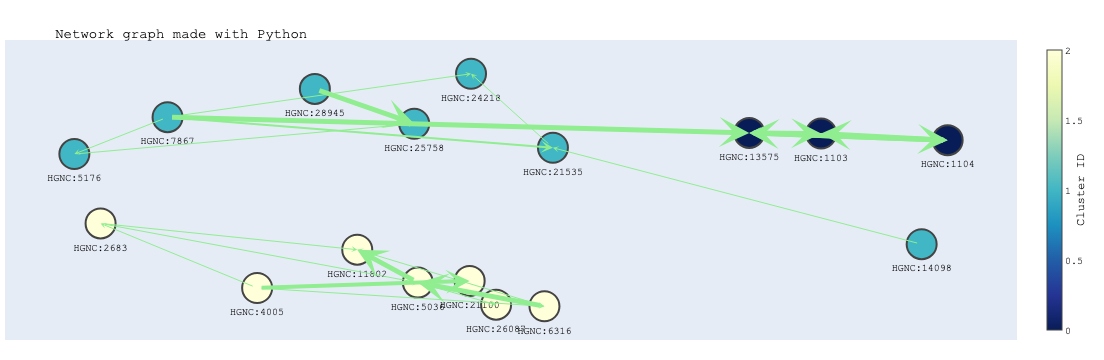

In [38]:
create_plotly_graph(G)